Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ft95zho because the default path (/home/student/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>


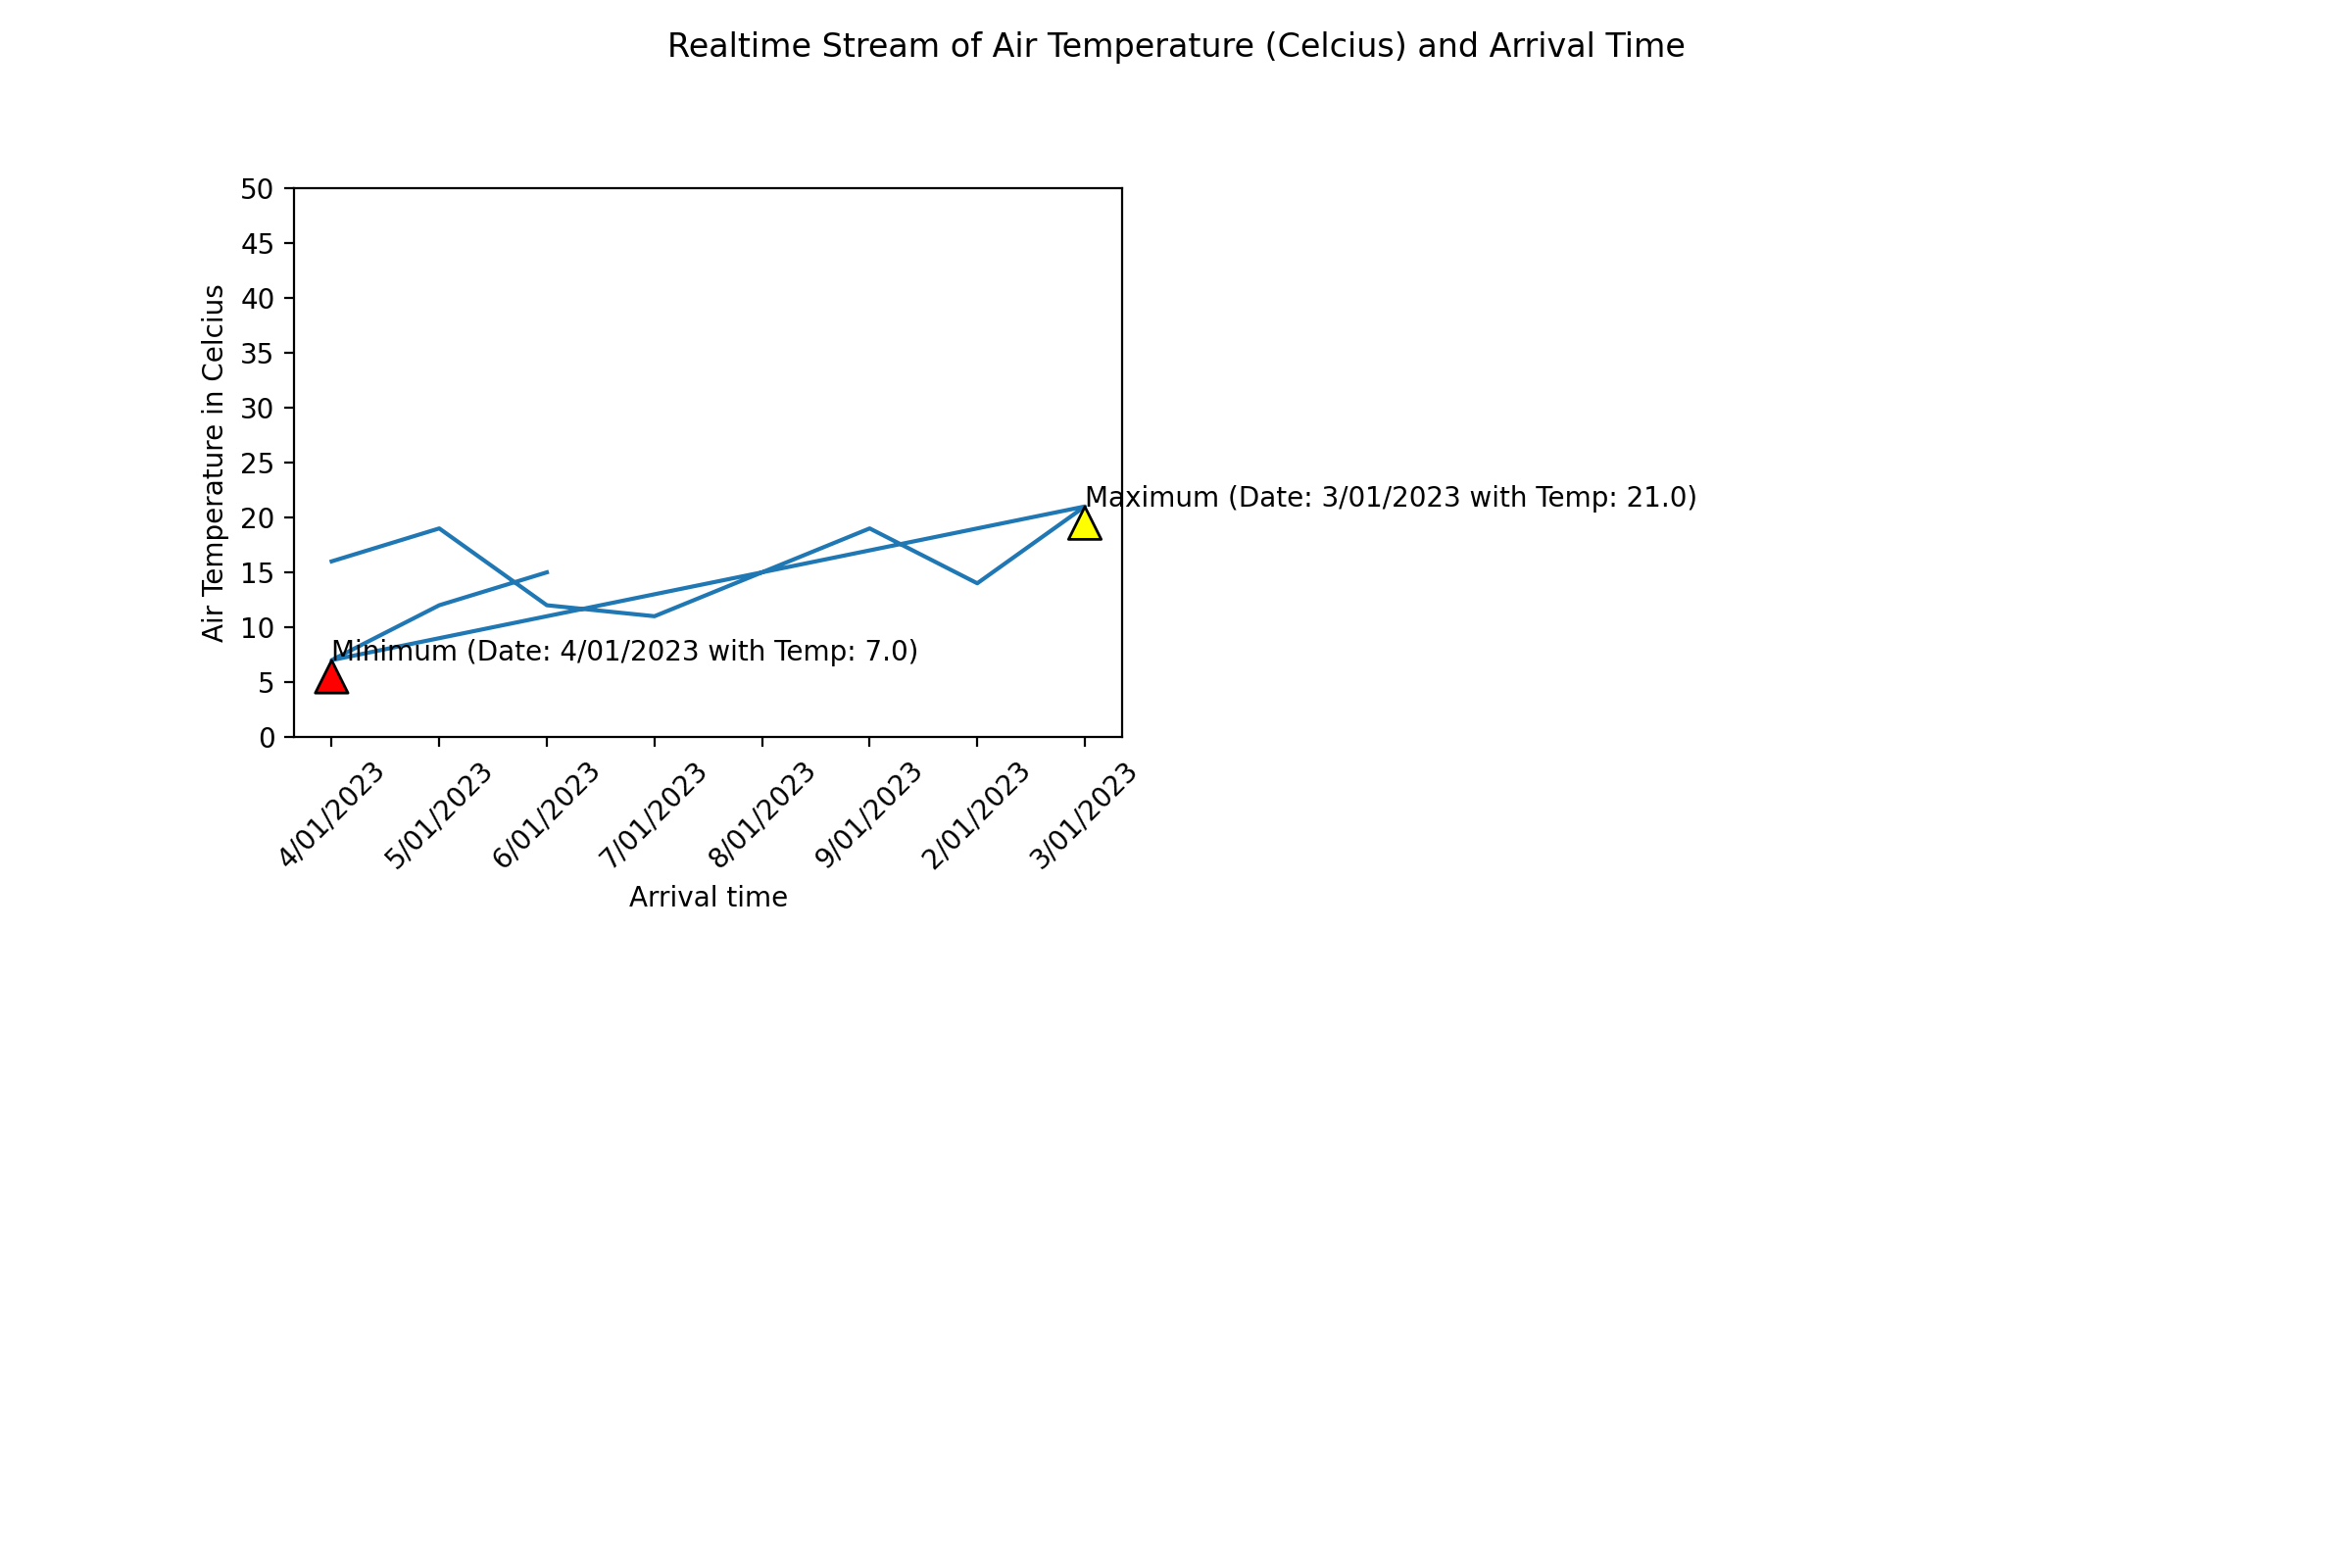

KeyboardInterrupt: 

In [1]:
from kafka import KafkaConsumer
from json import loads
import datetime as dt
import matplotlib.pyplot as plt
import statistics

# Required for Jupyter inline display
%matplotlib notebook

topic = "Climate"

def connect_kafka_consumer():
    _consumer = None
    try:
        _consumer = KafkaConsumer(
            topic,
            
            auto_offset_reset='earliest',
            # connecting to the server
            bootstrap_servers=['192.168.1.5:9092'],
            value_deserializer=lambda x: loads(
                x.decode('ascii')),
            api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer


def init_plot():
    try:
        width = 12
        height = 8

        # Initialise plot
        fig = plt.figure(figsize=(width, height))
        fig.suptitle(
            'Realtime Stream of Air Temperature (Celcius) and Arrival Time')

        # Create axis for plot
        ax = fig.add_subplot(221)
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (Celcius)')
        ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
        ax.set_ylim(0, 50)

        # Draw plot
        fig.show()
        fig.canvas.draw()

        return fig, ax

    except Exception as ex:
        print(str(ex))


def consume_messages(consumer, fig, asx):
    try:
        # Create arrays to store x & y values from Kafka stream.
        x, y = [], []

        # For each message from the incomming stream.
        for message in consumer:
            message = message.value
            # print(message)

            message_date = dt.datetime.fromisoformat(message['created_date']) # Clean the date from ISO to dd/mm/yy
            clean_date = message_date.strftime('%-d/%m/%Y')
            x.append(clean_date) # Append x & y values to arrays
            y.append(message['air_temperature_celcius'])

            # Start plotting when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y) # Plot all x & y values.
                ax.set_xlabel('Arrival time')
                ax.set_ylabel('Air Temperature in Celcius')
                ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
                ax.set_ylim(0, 50)
                ax.tick_params(axis='x', labelrotation=45) # Rotate dates to make them clear to see.

                # Add max & min arrows to graph.
                y_min = min(y) # Get the x,y coords for min position.
                x_min_pos = y.index(y_min)
                x_min = x[x_min_pos]
                y_max = max(y) # Get the x,y coords for the max position.
                x_max_pos = y.index(y_max)
                x_max = x[x_max_pos]
                # Label that will display Date & Temp for the max & min position.
                min_label = 'Minimum (Date: ' + x_min + ' with Temp: ' + str(y_min) + ')'
                max_label = 'Maximum (Date: ' + x_max + ' with Temp: ' + str(y_max) + ')'
                # Annotate axis creating arrows.
                ax.annotate(min_label, xy=(x_min, y_min), xytext=(
                    x_min, y_min), arrowprops=dict(facecolor='red', shrink=0.04))
                ax.annotate(max_label, xy=(x_max, y_max), xytext=(
                    x_max, y_max), arrowprops=dict(facecolor='yellow', shrink=0.04))

                fig.canvas.draw()
                
                # Pop the oldest value to make room for the new value.
                x.pop(0)
                y.pop(0)

        plt.close('all')
    except Exception as ex:
        print(str(ex))


if __name__ == '__main__':

    consumer = connect_kafka_consumer()
    fig, ax = init_plot()
    consume_messages(consumer, fig, ax)

In [4]:
import pymongo
import matplotlib.pyplot as plt

# Required for Jupyter inline display
%matplotlib notebook

# Connect to the MongoDB database
client = pymongo.MongoClient()
db = client.fit3182_assignment_db
collection = db.climate

# Retrieve hotspots' time from the database
pipeline = [
    {'$unwind': '$hotspots'},
    {'$project': {'_id': 0, 'hotspots.time': 1}}
]
result = collection.aggregate(pipeline)

# Count hotspots for each hour of the day
hour_data = [0] * 24
for entry in result:
    hour = entry['hotspots']['time'].hour
    hour_data[hour] += 1

# Prepare x and y values for plotting
x = list(range(24))
y = hour_data

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Hotspots per Hour')
ax.bar(x, y)
ax.set_xlabel('Hour in Day')
ax.set_ylabel('Total Number of Hotspots')

fig.show()
fig.canvas.draw()


ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused, Timeout: 30s, Topology Description: <TopologyDescription id: 647f254f06a8f8e7f395c766, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused')>]>

In [ ]:
import folium
import pymongo
from datetime import datetime

# Initial location: Melbourne
m = folium.Map(location=[-37.8409, 144.9464], zoom_start=7)

# Connect to the MongoDB database
client = pymongo.MongoClient()
db = client.fit3182_assignment_db
collection = db.climate

# Collect hotspots after this date, as it has the associated cause data.
pipeline = [
    {'$unwind': '$hotspots'},
    {'$match': {'hotspots.time': {'$gte': datetime(2021, 12, 31)}}}
]
result = collection.aggregate(pipeline)

# For each hotspot
for entry in result:
    hotspot = entry['hotspots']
    climate = entry

    # Get all data required for hotspot location and associated pop-up information
    cause = hotspot['cause']
    longitude = hotspot['longitude']
    latitude = hotspot['latitude']
    surface_temperature = hotspot['surface_temperature_celcius']
    air_temperature = climate['air_temperature_celcius']
    relative_humidity = climate['relative_humidity']

    # HTML string to display for pop-up information
    information = "<b>Cause:</b> %s<br><b>Surface Temperature:</b> %d<br><b>Air Temperature:</b> %d<br><b>Relative Humidity:</b> %d" % (
        cause, surface_temperature, air_temperature, relative_humidity)

    # If the cause is natural, add a blue marker; otherwise, use red.
    marker_color = "blue" if cause == 'natural' else "red"

    # Add a marker with a pop-up to the map
    folium.Marker(
        location=[latitude, longitude],
        popup=folium.Popup(html=information, max_width='100%'),
        icon=folium.Icon(color=marker_color, icon="info-sign"),
    ).add_to(m)

m
